In [1]:
import matplotlib.image as mpimg
import numpy as np
#import matplotlib.pyplot as plt
import cv2
import csv
from scipy.misc import imresize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, Lambda, Conv2D, Cropping2D, ELU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

def filter_out_minimal_steering_angles(image_list, remove_angles_less_than=0.1): # was 0.01
    filtered_ImageData = []
    for row in image_list:
        if (abs(row[1]) > remove_angles_less_than):
            filtered_ImageData.append((row[0],row[1]))
    return filtered_ImageData

def generate_left_recovery_data(image_list):
    filtered_ImageData = []
    for row in image_list:
        if (row[1] > 0.3): # shouldn't matter we filter out 0 also
            filtered_ImageData.append((row[0],row[1]))
    return filtered_ImageData

def generate_right_recovery_data(image_list):
    filtered_ImageData = []
    for row in image_list:
        if (row[1] < -0.3): # shouldn't matter we filter out 0 also
            filtered_ImageData.append((row[0],row[1]))
    return filtered_ImageData

def flip_image(input_filename, output_filename):
    image_data = cv2.imread(input_filename)
    cv2.imwrite(output_filename, cv2.flip(image_data, 1))
    
def morph_gradient_image(input_filename, output_filename):
    image_data = cv2.imread(input_filename)
    cv2.imwrite(output_filename, cv2.morphologyEx(image_data, cv2.MORPH_GRADIENT, np.ones((5,5),np.uint8)))    

def blur_image(input_filename, output_filename):
    image_data = cv2.imread(input_filename)
    kernel = np.ones((5,5),np.float32)/25
    cv2.imwrite(output_filename, cv2.blur(image_data,(5,5)))    

def binary_threshold_image(input_filename, output_filename):
    image_data = cv2.imread(input_filename)
    ret,thresh = cv2.threshold(image_data,127,255,cv2.THRESH_BINARY)
    cv2.imwrite(output_filename, thresh) 
    
def tozero_inv_threshold_image(input_filename, output_filename):
    image_data = cv2.imread(input_filename)
    ret,thresh = cv2.threshold(image_data,127,255,cv2.THRESH_TOZERO_INV)
    cv2.imwrite(output_filename, thresh) 
    
def grabcut_image(input_filename, output_filename):
    image_data = cv2.imread(input_filename)
    mask = np.zeros(image_data.shape[:2],np.uint8)

    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)

    rect = (0,50,450,290)
    cv2.grabCut(image_data,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
    image_data = image_data*mask2[:,:,np.newaxis]    
    cv2.imwrite(output_filename, image_data)    

def erode_image(input_filename, output_filename):
    image_data = cv2.imread(input_filename)
    cv2.imwrite(output_filename, cv2.erode(image_data,np.ones((5,5),np.uint8),iterations = 5))

def truncate_threshold_image(input_filename, output_filename):
    image_data = cv2.imread(input_filename)
    ret,thresh = cv2.threshold(image_data,127,255,cv2.THRESH_TRUNC)
    cv2.imwrite(output_filename, thresh)
    
def generate_blur_data(image_list, input_dir="IMG", output_dir="data/IMG_generated/"):
    blur = []

    for row in image_list:
        pos = row[0].find(input_dir)
        blur_name = output_dir + "blur_" + row[0][1 + pos + len(input_dir):]
        blur.append((blur_name, row[1]))
        if -1 != row[0].find("filtered"):
            blur_image(row[0], blur_name)
        else:     
            blur_image(row[0].strip(), blur_name)
    return blur    
    
def generate_morph_data(image_list, input_dir="IMG", output_dir="data/IMG_generated/"):
    morph = []

    for row in image_list:
        pos = row[0].find(input_dir)
        morph_name = output_dir + "morph_" + row[0][1 + pos + len(input_dir):]
        morph.append((morph_name, row[1]))
        if -1 != row[0].find("filtered"):
            morph_gradient_image(row[0], morph_name)
        else:     
            morph_gradient_image(row[0].strip(), morph_name)
    return morph        
    
def generate_tozero_inv_data(image_list, input_dir="IMG", output_dir="data/IMG_generated/"):
    tozero_inv = []

    for row in image_list:
        pos = row[0].find(input_dir)
        tozero_inv_name = output_dir + "tozero_inv_" + row[0][1 + pos + len(input_dir):]
        tozero_inv.append((tozero_inv_name, row[1]))
        if -1 != row[0].find("filtered"):
            tozero_inv_threshold_image(row[0], tozero_inv_name)
        else:     
            tozero_inv_threshold_image(row[0].strip(), tozero_inv_name)
    return tozero_inv    
    
def generate_binary_data(image_list, input_dir="IMG", output_dir="data/IMG_generated/"):
    binary = []

    for row in image_list:
        pos = row[0].find(input_dir)
        binary_name = output_dir + "binary_" + row[0][1 + pos + len(input_dir):]
        binary.append((binary_name, row[1]))
        if -1 != row[0].find("filtered"):
            binary_threshold_image(row[0], binary_name)
        else:     
            binary_threshold_image(row[0].strip(), binary_name)
    return binary    
    
def generate_grabcut_data(image_list, input_dir="IMG", output_dir="data/IMG_generated/"):
    grabcut = []

    for row in image_list:
        pos = row[0].find(input_dir)
        grabcut_name = output_dir + "grabcut_" + row[0][1 + pos + len(input_dir):]
        grabcut.append((grabcut_name, row[1]))
        if -1 != row[0].find("filtered"):
            grabcut_image(row[0], grabcut_name)
        else:     
            grabcut_image(row[0].strip(), grabcut_name)
    return grabcut    
    
def generate_truncated_data(image_list, input_dir="IMG", output_dir="data/IMG_generated/"):
    truncate = []

    for row in image_list:
        pos = row[0].find(input_dir)
        truncate_name = output_dir + "truncate_" + row[0][1 + pos + len(input_dir):]
        truncate.append((truncate_name, row[1]))
        if -1 != row[0].find("filtered"):
            truncate_threshold_image(row[0], truncate_name)
        else:     
            truncate_threshold_image(row[0].strip(), truncate_name)
    return truncate


 #def dilate_image(filename):
#    image_data = cv2.imread("data/" + filename, 0)
#    return cv2.dilate(image_data,np.ones((5,5),np.uint8),iterations = 1)   
    
#def open_image(filename):
#    image_data = cv2.imread("data/" + filename, 0)
#    return cv2.morphologyEx(image_data, cv2.MORPH_OPEN, np.ones((5,5),np.uint8))


#blackhat = cv2.morphologyEx(img, cv2.MORPH_BLACKHAT, kernel)
#http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html#non-local-means
#dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)
#fastNlMeansDenoisingColoredMulti

def generate_erode_data(image_list, input_dir="IMG", output_dir="data/IMG_generated/"):
    erode = []

    for row in image_list:
        pos = row[0].find(input_dir)
        erode_name = output_dir + "erode_" + row[0][1 + pos + len(input_dir):]
        erode.append((erode_name, row[1]))
        if -1 != row[0].find("filtered"):
            erode_image(row[0], erode_name)
        else:     
            erode_image(row[0].strip(), erode_name)
    return erode

def generate_flipped_data(image_list, input_dir="IMG", output_dir="data/IMG_generated/"):
    flipped = []

    for row in image_list:
        pos = row[0].find(input_dir)
        flipped_name = output_dir + "flipped_" + row[0][(pos+4):]
        flipped.append((flipped_name, -1 * row[1]))
        flip_image(row[0], flipped_name)
    return flipped

def read_driving_info_from_file(filename):
    X_center = []
    Y_center = []
    X_left = []
    Y_left = []
    X_right = []
    Y_right = []
    correction = 0.3

    with open(filename, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            X_center.append("data/" + row[0].strip())
            Y_center.append(float(row[3]))
            X_left.append("data/" + row[1].strip()) #left
            Y_left.append(float(row[3]) + correction)
            X_right.append("data/" + row[2].strip()) #right
            Y_right.append(float(row[3]) - correction)
    return list(zip(X_center,Y_center)), list(zip(X_left,Y_left)), list(zip(X_right,Y_right))

def image_generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                original_data = mpimg.imread(batch_sample[0])
#                new_img = cv2.cvtColor(original_data, cv2.COLOR_RGB2YUV)
                images.append(original_data)
#                images.append(new_img)
                angles.append(float(batch_sample[1]))
            yield shuffle(np.array(images), np.array(angles))

def resize_images(image):
    import tensorflow as tf
    #image = tf.image.rgb_to_hsv(image)
    image = tf.image.random_brightness(image, max_delta=32. / 255.)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.5, upper=1.5)
    return tf.image.resize_images(image, (64, 64))#66,200



center, left, right = read_driving_info_from_file("data/driving_log.csv")
all_data = []
all_data.extend(center)
#all_data.extend(left)
#all_data.extend(right)

left_recovery_data = generate_left_recovery_data(left)
print(len(left_recovery_data))
all_data.extend(left_recovery_data)
right_recovery_data = generate_right_recovery_data(right)
print(len(right_recovery_data))
all_data.extend(right_recovery_data)

print("Total Number of Center Steering Angle Samples: ", len(center))
print("Total Number of Left Steering Angle Samples: ", len(left_recovery_data))
print("Total Number of Right Steering Angle Samples: ", len(right_recovery_data))
print("Total Number of Steering Angle Samples: ", len(all_data))
print("Started Image Generation!")  

augmented_ImageData = []
print("Generating flipped data...")
#print("augmented_ImageData, samples %d" % len(augmented_ImageData))
flipped_all_data = generate_flipped_data(all_data)

print("Adding original and flipped data to master list...")
augmented_ImageData.extend(all_data) 
augmented_ImageData.extend(flipped_all_data) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Filtering out minimal steering angles...")
all_data_filtered = filter_out_minimal_steering_angles(all_data)

print("* Generating blur data from filtered data...")
all_data_blur = generate_blur_data(all_data_filtered)
augmented_ImageData.extend(all_data_blur) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating binary data from filtered data...")
all_data_binary = generate_binary_data(all_data_filtered)
augmented_ImageData.extend(all_data_binary) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating erode data from filtered data...")
all_data_eroded = generate_erode_data(all_data_filtered)
augmented_ImageData.extend(all_data_eroded) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating morph data from filtered data...")
all_data_morph = generate_morph_data(all_data_filtered)
augmented_ImageData.extend(all_data_morph) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating tozero inv data from filtered data...")
all_data_tozero_inv = generate_tozero_inv_data(all_data_filtered)
augmented_ImageData.extend(all_data_tozero_inv) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating truncated data from filtered data...")
all_data_truncated = generate_truncated_data(all_data_filtered)
augmented_ImageData.extend(all_data_truncated) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Filtering out minimal steering angles...")
flipped_all_data_filtered = filter_out_minimal_steering_angles(flipped_all_data)

print("* Generating flipped blur data from flipped filtered data...")
flipped_filtered_blur = generate_blur_data(flipped_all_data_filtered, input_dir="IMG_generated")
augmented_ImageData.extend(flipped_filtered_blur) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating flipped binary data from flipped filtered data...")
flipped_filtered_binary = generate_binary_data(flipped_all_data_filtered, input_dir="IMG_generated")
augmented_ImageData.extend(flipped_filtered_binary) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating flipped erode data from flipped filtered data...")
flipped_filtered_eroded = generate_erode_data(flipped_all_data_filtered, input_dir="IMG_generated")
augmented_ImageData.extend(flipped_filtered_eroded) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating flipped morph data from flipped filtered data...")
flipped_filtered_morph = generate_morph_data(flipped_all_data_filtered, input_dir="IMG_generated")
augmented_ImageData.extend(flipped_filtered_morph) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating flipped tozero inv data from flipped filtered data...")
flipped_filtered_tozero_inv = generate_tozero_inv_data(flipped_all_data_filtered, input_dir="IMG_generated")
augmented_ImageData.extend(flipped_filtered_tozero_inv) 
print("augmented_ImageData has %d samples" % len(augmented_ImageData))

print("* Generating flipped truncated data from flipped filtered data...")
flipped_filtered_truncated = generate_truncated_data(flipped_all_data_filtered, input_dir="IMG_generated")
augmented_ImageData.extend(flipped_filtered_truncated) 



#print("Generating grabcut data from filtered data...")
#all_data_grabcut = generate_grabcut_data(all_data_filtered)
#augmented_ImageData.extend(all_data_grabcut) 



    
print("Writing csv file...")
out = open('driving_log_extra.csv', 'w')
for row in augmented_ImageData:
    out.write('%s,%.10f\n' % (row[0], row[1]))
out.close()
      
print("Completed Image Generation!")   
print("augmented_ImageData has %d samples" % len(augmented_ImageData))



Using TensorFlow backend.


1900
1775
Total Number of Center Steering Angle Samples:  8036
Total Number of Left Steering Angle Samples:  1900
Total Number of Right Steering Angle Samples:  1775
Total Number of Steering Angle Samples:  11711
Started Image Generation!
Generating flipped data...
Adding original and flipped data to master list...
augmented_ImageData has 23422 samples
* Filtering out minimal steering angles...
* Generating blur data from filtered data...
augmented_ImageData has 29210 samples
* Generating binary data from filtered data...
augmented_ImageData has 34998 samples
* Generating erode data from filtered data...
augmented_ImageData has 40786 samples
* Generating morph data from filtered data...
augmented_ImageData has 46574 samples
* Generating tozero inv data from filtered data...
augmented_ImageData has 52362 samples
* Generating truncated data from filtered data...
augmented_ImageData has 58150 samples
* Filtering out minimal steering angles...
* Generating flipped blur data from flipped fi

In [ ]:
def resize_images(image):
    import tensorflow as tf
    return tf.image.resize_images(image, (64, 64))#66,200

def brighten_images(image):
    import tensorflow as tf
    return tf.image.random_brightness(image[1, :, :, :], max_delta=32. / 255.)

def saturate_images(image):
    import tensorflow as tf
    return tf.image.random_saturation(image, lower=0.5, upper=1.5)

def hue_images(image):
    import tensorflow as tf
    return tf.image.random_hue(image, max_delta=0.2)

def contrast_images(image):
    import tensorflow as tf
    return tf.image.random_contrast(image, lower=0.5, upper=1.5)
    

Image_train, Image_validation = train_test_split(augmented_ImageData, test_size=0.20) #was 0.05 for run22
print("data split!")
print("training samples: ", len(Image_train))
print("validation samples: ", len(Image_validation))            

train_gen = image_generator(Image_train, batch_size=32) # was 256
validation_gen = image_generator(Image_validation, batch_size=32)


# Create modified nvidia model
model = Sequential()


#model.add(Cropping2D(cropping=((80, 20), (1, 1)), dim_ordering='tf', input_shape=(160, 320, 3)))
#model.add(Lambda(resize_images))
##model.add(Lambda(lambda x: x/127.5 - 1.))
#model.add(Lambda(lambda x: (x / 255.0) - 0.5))
#model.add(Convolution2D(24,5,5, activation='relu', border_mode="valid", subsample=(2,2)))
##model.add(Activation('relu'))
#model.add(Convolution2D(36,5,5, activation='relu', border_mode="valid", subsample=(2,2)))
##model.add(Activation('relu'))
#model.add(Convolution2D(48,5,5, activation='relu', border_mode="valid", subsample=(2,2)))
##model.add(Activation('relu'))
#model.add(Convolution2D(64,3,3, activation='relu', border_mode="valid", subsample=(1,1)))
##model.add(Activation('relu'))
#model.add(Convolution2D(64,3,3, activation='relu', border_mode="valid", subsample=(1,1)))
##model.add(Dropout(0.5)) # revert back to this dropout only
#model.add(Flatten())
#model.add(Dropout(0.5))
#model.add(Dense(1164, activation='relu'))
##model.add(Activation('relu'))
#model.add(Dense(100, activation='relu'))
##model.add(Activation('relu'))
#model.add(Dense(50, activation='relu'))
##model.add(Activation('relu'))
#model.add(Dense(10, activation='relu'))
##model.add(Activation('relu'))
#model.add(Dense(1)) # try without activation

#model.add(Cropping2D(cropping=((80, 20), (1, 1)), dim_ordering='tf', input_shape=(160, 320, 3)))
#model.add(Lambda(resize_images))
#model.add(Lambda(lambda x: (x / 255.0) - 0.5))
#model.add(Convolution2D(24, 5, 5, border_mode="valid", subsample=(2, 2), activation="elu"))
#model.add(Convolution2D(36, 5, 5, border_mode="valid", subsample=(2, 2), activation="elu"))
#model.add(Convolution2D(48, 5, 5, border_mode="valid", subsample=(2, 2), activation="elu"))
#model.add(Convolution2D(64, 3, 3, border_mode="valid", subsample=(1, 1), activation="elu"))
#model.add(Convolution2D(64, 3, 3, border_mode="valid", subsample=(1, 1), activation="elu"))
#model.add(Flatten())
#model.add(Dense(1164, activation="elu"))
#model.add(Dense(100, activation="elu"))
#model.add(Dense(50, activation="elu"))
#model.add(Dense(10, activation="elu"))
#model.add(Dense(1, activation="linear"))

model.add(Cropping2D(cropping=((70, 25), (5, 5)), dim_ordering='tf', input_shape=(160, 320, 3)))
#model.add(Lambda(brighten_images))
#model.add(Lambda(saturate_images))
#model.add(Lambda(hue_images))
#model.add(Lambda(contrast_images))
model.add(Lambda(resize_images))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='elu')) #this and the next one I forgot to change
model.add(Convolution2D(64, 3, 3, activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1164, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='linear')) #was  tanh

#model.add(Cropping2D(cropping=((35, 20), (0, 0)),
#                     dim_ordering='tf', # default
#                     input_shape=(160, 320, 3)))

#model.add(Lambda(resize_images))
#model.add(Lambda(lambda x: (x/255.0) - 0.5))
#model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
#model.add(ELU())
#model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
#model.add(ELU())
#model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
#model.add(Flatten())
#model.add(Dropout(.2))
#model.add(ELU())
#model.add(Dense(512))
#model.add(Dropout(.5))
#model.add(ELU())
#model.add(Dense(1))

optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
print(model.summary())
checkpoint = ModelCheckpoint(filepath="all26_model_weights{epoch:02d}.h5", verbose=0, save_best_only=False)

model.fit_generator(train_gen, samples_per_epoch=len(Image_train), 
                    validation_data=validation_gen, nb_val_samples=len(Image_validation),
                    nb_epoch=10, callbacks=[checkpoint])

# Save off model info
model.save("all26_model.h5")

f = open("all26_model.json", "w")
f.write(model.to_json())
f.close()
print("model saved")

data split!
training samples:  74302
validation samples:  18576
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_12 (Cropping2D)       (None, 65, 310, 3)    0           cropping2d_input_12[0][0]        
____________________________________________________________________________________________________
lambda_48 (Lambda)               (None, 64, 64, 3)     0           cropping2d_12[0][0]              
____________________________________________________________________________________________________
lambda_49 (Lambda)               (None, 64, 64, 3)     0           lambda_48[0][0]                  
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 30, 30, 24)    1824        lambda_49[0][0]                  
___________________________

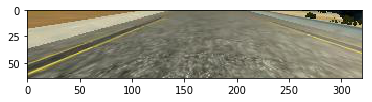

In [11]:
import cv2
import matplotlib.pylab as plt
%matplotlib inline
#img = cv2.imread("left_2016_12_01_13_33_16_555.jpg", 0)

img = plt.imread("left_2016_12_01_13_33_16_555.jpg")

def preprocess_image(img):
    img_crop = img[70:135, :, :]
#    img_resize = cv2.resize(img_crop, (200, 66))

    return img_crop

cropped_img = preprocess_image(img)

plt.imshow(cropped_img)


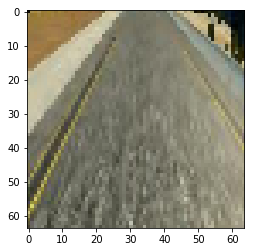

In [13]:
img_resize = cv2.resize(cropped_img, (64, 64))
plt.imshow(img_resize)

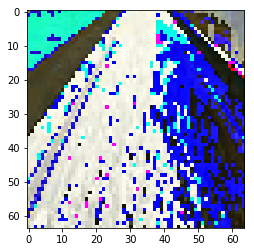

In [15]:
img_norm = ((img_resize / 255.0) - 0.5)
plt.imshow(img_norm)